In [25]:
!rm -rf /content/data_haptic
!unzip -q /content/data_haptic.zip -d /content/data_haptic
!ls /content/data_haptic

data_haptic


## **Task Classification**

In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
np.random.seed(SEED); random.seed(SEED)
BASE_DIR = "/content/data_haptic/data_haptic"
USERS = [f"u{i}" for i in range(1, 9)]
LETTERS = list("abcdefg")
SEQ_LEN = 512

AUG_NOISE_STD = 0.10
AUG_JITTER = 32
AUG_GAIN_RANGE = (0.85, 1.15)
TIME_STRETCH_MAX = 0.1
LABEL_NOISE_LEVEL = 0.1

In [ ]:
def read_force_csv(path):
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number])
    return num.iloc[:, :3].to_numpy(dtype=float)

def load_all_recordings(base_dir):
    rows = []
    for u in USERS:
        for t in LETTERS:
            path = os.path.join(base_dir, u, t, "force.csv")
            if os.path.exists(path):
                rows.append({"user": u, "task": t, "seq": read_force_csv(path)})
    return pd.DataFrame(rows)

def resample_to_len(x, L=SEQ_LEN):
    T = x.shape[0]
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[:,i]) for i in range(x.shape[1])], axis=1)

def _tiny_time_stretch(x, max_rate=TIME_STRETCH_MAX):
    rate = 1.0 + np.random.uniform(-max_rate, max_rate)
    T = x.shape[0]
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, int(round(T * rate)))
    y = np.stack([np.interp(dst, src, x[:, i]) for i in range(x.shape[1])], axis=1)
    return resample_to_len(y, SEQ_LEN)

def synth_variation(x13):
    y = _tiny_time_stretch(x13)
    s = np.random.randint(-AUG_JITTER, AUG_JITTER + 1)
    if s != 0: y = np.roll(y, shift=s, axis=0)
    gains = np.random.uniform(AUG_GAIN_RANGE[0], AUG_GAIN_RANGE[1], size=(1, y.shape[1]))
    y = y * gains + np.random.normal(0, AUG_NOISE_STD, size=y.shape)
    return y

In [ ]:
# Feature Extraction

def _zcr(x):
    s = np.sign(x)
    return np.mean((s[1:] != s[:-1]).astype(np.float32), axis=0)

def per_timestep_13d(F, fs=250):
    F = np.nan_to_num(F.astype(np.float32))
    F = resample_to_len(F, SEQ_LEN)
    d1 = np.gradient(F, axis=0) * fs
    d2 = np.gradient(d1, axis=0) * fs
    d3 = np.gradient(d2, axis=0) * fs
    norm = lambda x: np.linalg.norm(x, axis=1, keepdims=True)
    return np.concatenate([F, norm(F), d1, norm(d1), d2, norm(d2), norm(d3)], axis=1)

def agg_features_from_seq(x13):
    f = {
        "mean":   np.mean(x13, axis=0),
        "std":    np.std(x13, axis=0) + 1e-8,
        "min":    np.min(x13, axis=0),
        "max":    np.max(x13, axis=0),
        "median": np.median(x13, axis=0),
        "q25":    np.percentile(x13, 25, axis=0),
        "q75":    np.percentile(x13, 75, axis=0),
        "rms":    np.sqrt(np.mean(x13**2, axis=0)),
        "energy": np.mean(x13**2, axis=0),
        "zcr":    _zcr(x13)
    }
    f["iqr"] = f["q75"] - f["q25"]
    keys = ["mean","std","min","max","median","q25","q75","iqr","rms","energy","zcr"]
    return np.concatenate([f[k] for k in keys], axis=0)

In [ ]:
def inject_label_noise(y, noise_level=0.1, num_classes=7):
    y_noisy = y.copy()
    n = int(len(y) * noise_level)
    idx = np.random.choice(len(y), n, replace=False)
    for i in idx:
        y_noisy[i] = np.random.choice([c for c in range(num_classes) if c != y[i]])
    return y_noisy

In [ ]:
def build_task_dataset_for_user(df, user, recs_per_task=15):
    rows = df[df.user == user]
    X_list, y_list, g_list = [], [], []
    rec_id = 0
    for tidx, t in enumerate(LETTERS):
        rt = rows[rows.task == t]
        if len(rt) == 0: continue
        base_seq = per_timestep_13d(rt.iloc[0].seq)
        for r in range(recs_per_task):
            seq = base_seq if r == 0 else synth_variation(base_seq)
            feat = agg_features_from_seq(seq)
            X_list.append(feat)
            y_list.append(tidx)
            g_list.append(rec_id)
            rec_id += 1
    if not X_list:
        return None, None, None
    return np.stack(X_list), np.array(y_list), np.array(g_list)

In [ ]:
# Models

def get_task_model(name):
    if name == "RF":
        return RandomForestClassifier(n_estimators=30, max_depth=4, min_samples_leaf=20, max_features="log2", bootstrap=True, random_state=SEED)
    if name == "LogReg":
        return LogisticRegression(solver="saga", max_iter=3000, multi_class="multinomial", C=1.0, random_state=SEED)
    if name == "SVM":
        return LinearSVC(C=1.0, max_iter=3000, class_weight='balanced', random_state=SEED)
    raise ValueError("Choose from RF, LogReg, SVM")

# Cross-validation per user
def task_gkf_one_user(df, user, model_name="RF", n_splits=5, show_confusion=False):
    Xrec, yrec, groups = build_task_dataset_for_user(df, user)
    assert Xrec is not None, f"No data for {user}"
    gkf = GroupKFold(n_splits=n_splits)
    fold_acc = []
    for fold, (tri, tei) in enumerate(gkf.split(Xrec, yrec, groups), 1):
        Xtr, ytr = Xrec[tri], yrec[tri]
        Xte, yte = Xrec[tei], yrec[tei]
        ytr = inject_label_noise(ytr, noise_level=LABEL_NOISE_LEVEL)
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
        model = get_task_model(model_name)
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        acc = (ypred == yte).mean()
        fold_acc.append(acc)
        if show_confusion:
            print(f"{user} | {model_name} | Fold {fold} | Acc: {acc:.3f}")
            print(classification_report(yte, ypred, target_names=LETTERS, digits=3))
            cm = confusion_matrix(yte, ypred)
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=LETTERS, yticklabels=LETTERS)
            plt.title(f"{user} — {model_name} — Fold {fold}")
            plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    mean_acc = np.mean(fold_acc)
    print(f"{user} | {model_name} | MeanAcc: {mean_acc:.3f}")
    return mean_acc

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_letter_recognition_gkf(df, model_names=("RF", "LogReg", "SVM")):
    all_results = []

    for u in tqdm(USERS, desc="Users"):
        for model_name in model_names:
            Xrec, yrec, groups = build_task_dataset_for_user(df, u)
            if Xrec is None:
                continue

            gkf = GroupKFold(n_splits=5)
            all_y_true, all_y_pred = [], []

            for fold, (tri, tei) in enumerate(gkf.split(Xrec, yrec, groups=groups), 1):
                Xtr, ytr = Xrec[tri], yrec[tri]
                Xte, yte = Xrec[tei], yrec[tei]

                ytr = inject_label_noise(ytr, noise_level=LABEL_NOISE_LEVEL)

                scaler = StandardScaler()
                Xtr = scaler.fit_transform(Xtr)
                Xte = scaler.transform(Xte)

                model = get_task_model(model_name)
                model.fit(Xtr, ytr)
                ypred = model.predict(Xte)

                all_y_true.extend(yte)
                all_y_pred.extend(ypred)

            acc = np.mean(np.array(all_y_true) == np.array(all_y_pred))
            prec, rec, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='macro', zero_division=0)

            all_results.append({
                "User": u,
                "Model": model_name,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "y_true": all_y_true,
                "y_pred": all_y_pred
            })

    df_results = pd.DataFrame(all_results)

    print("\n Per-user metrics:")
    display(df_results[["User", "Model", "Accuracy", "Precision", "Recall", "F1"]])

    print("\n Average accuracy per model:")
    summary = df_results.groupby("Model")[["Accuracy", "Precision", "Recall", "F1"]].mean().reset_index().sort_values("Accuracy", ascending=False)
    display(summary)

    # Accuracy bar plot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=summary, x="Model", y="Accuracy", palette="Set2")
    plt.title("Model Accuracy Comparison", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Confusion matrices
    print("\n Confusion Matrices:")
    for model in model_names:
        y_true = np.concatenate(df_results[df_results.Model == model]["y_true"].values)
        y_pred = np.concatenate(df_results[df_results.Model == model]["y_pred"].values)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LETTERS, yticklabels=LETTERS)
        plt.title(f"Confusion Matrix - {model}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    return df_results, summary

Users:   0%|          | 0/8 [00:00<?, ?it/s]


 Per-user metrics:


,User,Model,Accuracy,Precision,Recall,F1
0,u1,RF,0.923810,0.930672,0.923810,0.922747
1,u1,LogReg,0.942857,0.945238,0.942857,0.942781
2,u1,SVM,0.952381,0.954622,0.952381,0.952648
3,u2,RF,0.800000,0.842641,0.800000,0.794021
4,u2,LogReg,0.980952,0.981548,0.980952,0.980942
5,u2,SVM,0.971429,0.974265,0.971429,0.970590
6,u3,RF,0.819048,0.851517,0.819048,0.812586
7,u3,LogReg,0.961905,0.963690,0.961905,0.961521
8,u3,SVM,0.895238,0.902333,0.895238,0.896230
9,u4,RF,0.838095,0.867036,0.838095,0.832904



 Average accuracy per model:


,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.971429,0.973586,0.971429,0.971384
2,SVM,0.922619,0.930667,0.922619,0.923239
1,RF,0.848810,0.875252,0.848810,0.844379


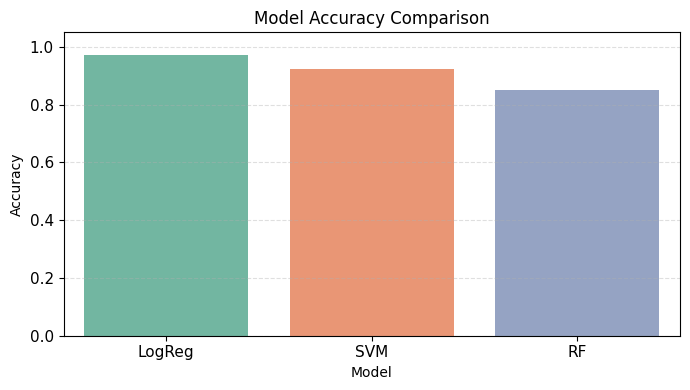


 Confusion Matrices:


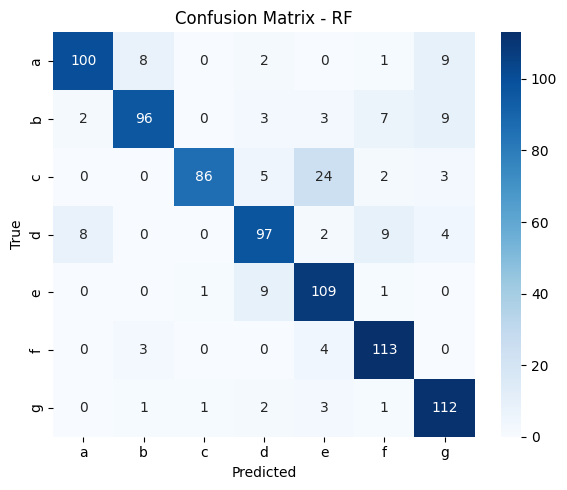

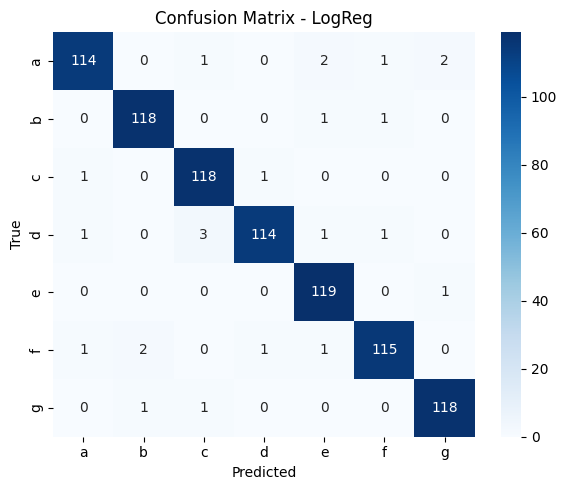

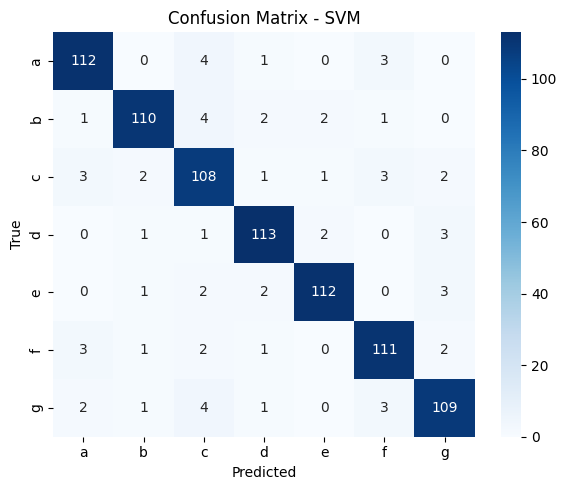

In [ ]:
df = load_all_recordings(BASE_DIR)
results_df, summary_df = run_letter_recognition_gkf(df)